## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## First, I'll compute the camera calibration using chessboard images and calculate distortion coefficients using opencv

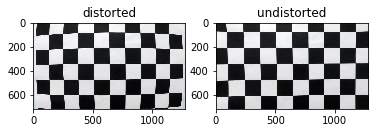

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

def get_coeff():
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    img = cv2.imread('camera_cal/calibration1.jpg')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #Calculating distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx,dist

def distortion_correction(gray,mtx,dist):
    dst = cv2.undistort(gray, mtx, dist, None, mtx)
    return dst

#get coeff 
mtx,dist = get_coeff()

#trying out on an image
img = cv2.imread('camera_cal/calibration1.jpg')
gray = img#cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dst = distortion_correction(gray,mtx,dist)
plt.figure(0)
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.title('distorted')
plt.subplot(122)
plt.imshow(dst,cmap='gray')
plt.title('undistorted')
plt.show()

## Pipeline to generate lane line binary masks

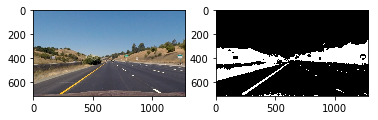

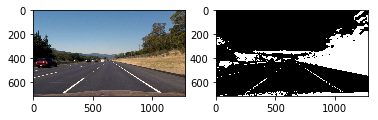

In [2]:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobeld = cv2.Sobel(gray,cv2.CV_64F,1,0)
    else:
        sobeld = cv2.Sobel(gray,cv2.CV_64F,0,1)
        
        
    # 3) Take the absolute value of the derivative or gradient
    absval = np.absolute(sobeld) 
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    skaled = np.zeros(absval.shape)
    #skaled = np.uint8(255*absval/np.max(absval))

    skaled = cv2.normalize(absval,skaled, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    skaled[skaled<=thresh[0]] = 0
    skaled[skaled>=thresh[1]]  = 0
    skaled[skaled!=0]  = 1
    # 6) Return this mask as your binary_output image
    binary_output = skaled
    return binary_output

def mag_thresholding(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    gradx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    grady = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.multiply(gradx,gradx) + np.multiply(grady,grady))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    mag = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    mask = np.ones(mag.shape)
    mask[mag<thresh[0]] = 0
    mask[mag>thresh[1]] = 0
    # 6) Return this mask as your binary_output image
    binary_output =mask
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gray = histeq(gray)

    # 2) Take the gradient in x and y separately
    gradx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    grady = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(gradx)
    abs_sobely = np.absolute(grady)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    sobel_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros(gradx.shape)
    mask[(sobel_dir>thresh[0]) & (sobel_dir<thresh[1])]  = 1
    # 6) Return this mask as your binary_output image
    binary_output = mask
    return binary_output


def gradient_thresh(image,threshxy=(0,255),mag_thresh=(0,255),dir_thresh = (0,np.pi/2)):
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh = threshxy)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh = threshxy)
    mag_binary = mag_thresholding(image, sobel_kernel=ksize,thresh = mag_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh = dir_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1)|(grady==1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined,dir_binary

def histeq(img):
    ''' Applies histogram equalization to the grayscale Image
    This helps in case of low light images
    '''
    clahe_obj = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    return clahe_obj.apply(img)

# Edit this function to create your own pipeline.
def pipeline_binarize1(img, no_grad = 1,s_thresh=(150, 255), gradxy_thresh=(30, 130),mag_thresh=(40,130),dir_thresh=(np.pi/8,np.pi/2)):
    img1 = np.copy(img)
    img = np.copy(img)
    img = np.asarray(img,dtype=np.float32)
#    img = cv2.GaussianBlur(img,(5,5),0)

    t1 = img[:,:,0]
    t2 = img[:,:,1]
    t3 = img[:,:,2]
    m1 = np.max(img,axis=2)
    n1 = np.min(img,axis=2)
    t3 = (t3+5.0)/(m1+5.0)
    k=np.zeros_like(t3)
    k[(t3<0.75)] = 1
    k = np.asarray(k,dtype=np.uint8)
    combined_binary = np.zeros_like(k)
    combined_binary[(k == 1)] = 1
    
    hls = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    gradbinary,dir_binary = gradient_thresh(img1,gradxy_thresh,mag_thresh,dir_thresh)

    s_binary = np.zeros_like(k)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    img_lab = cv2.cvtColor(img1,cv2.COLOR_RGB2LAB)

    yellow_binary = np.zeros_like(k)
    
    lb_channel = np.squeeze(img_lab[:,:,2])
    ll_channel = np.squeeze(img_lab[:,:,0])
    
    s_binary[(lb_channel>175)] = 1
    s_binary[(ll_channel>190)] = 1
        
    t4 = (m1-n1+5.0)/ (m1+5.0)
    k=np.zeros_like(s_binary)
    k[(t4<0.1)] = 1
    k[m1<120] = 0
    k = np.asarray(k,dtype=np.uint8)
    
    combined_binary[((k == 1)&(s_binary==1))] = 1
    if(no_grad==0):
        combined_binary[gradbinary==1]=1
   # combined_binary[(gradbinary==1)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(combined_binary), combined_binary, combined_binary)) * 255
    
    return combined_binary,color_binary


#Lets test our pipeline on couple of the images

img_test1 = mpimg.imread('test_images/straight_lines1.jpg')
img_test1 = distortion_correction(img_test1,mtx,dist)
binarized_test1,temp =  pipeline_binarize1(img_test1)
plt.figure(1)
plt.subplot(121)
plt.imshow(img_test1)
plt.subplot(122)
plt.imshow(binarized_test1,cmap='gray')
plt.show()

img_test1 = mpimg.imread('test_images/straight_lines2.jpg')
img_test1 = distortion_correction(img_test1,mtx,dist)
binarized_test1,temp =  pipeline_binarize1(img_test1)
plt.figure(2)
plt.subplot(121)
plt.imshow(img_test1)
plt.subplot(122)
plt.imshow(binarized_test1,cmap='gray')
plt.show()


## Perspective transformation and Inverse Transformation

255


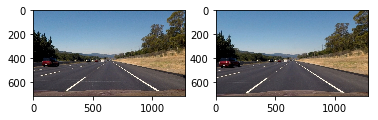

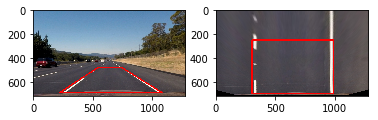

In [3]:
def getperpcoeff(w=1280,h=760):
    widthcoeff = w/1280.0
    heightcoeff = h/720.0
    src = np.float32([[224,690],[1078,690],[740,480],[545,480]])
    dstpts = np.float32([[300,700],[980,700],[980,250],[300,250]])
    M = cv2.getPerspectiveTransform(src,dstpts)
    return M
def getinvperpcoeff(w=1280,h=760):
    widthcoeff = w/1280.0
    heightcoeff = h/720.0
    dstpts = np.float32([[224,690],[1078,690],[740,480],[545,480]])
    src = np.float32([[300,700],[980,700],[980,250],[300,250]])
    M = cv2.getPerspectiveTransform(src,dstpts)
    return M

def do_persp(image,M):
    dst = cv2.warpPerspective(image,M,(image.shape[1],image.shape[0]))
    return dst

src = np.float32([[224,690],[1078,690],[740,480],[545,480]])
dstpts = np.float32([[300,700],[980,700],[980,250],[300,250]])

M = getperpcoeff()

img_original = mpimg.imread('test_images/straight_lines2.jpg')
mtx,dist = get_coeff()
img_test1 = distortion_correction(img_original,mtx,dist)
binarized_test1,temp =  pipeline_binarize1(img_test1)

print(np.amax(img_original-img_test1))
plt.figure(5)
plt.subplot(121)
plt.imshow(img_original)
plt.subplot(122)
plt.imshow(img_test1,cmap='gray')
plt.show()

dst = do_persp(img_test1,M)
plt.figure(3)
plt.subplot(121)
img_test1 = cv2.polylines(img_test1, np.int32([src]), True, (255,0,0), 10)
plt.imshow(img_test1)
plt.subplot(122)
cv2.polylines(dst, np.int32([dstpts]), True,  (255,0,0), 10)
plt.imshow(dst,cmap='gray')
plt.show()

## Stand-Alone lane detection and Continuous Lane Detection Algorithm

In [4]:
def findlinesfirst(binary_warped,left_line,right_line,lane_width,thresh=1):
# Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    ix1 = int(binary_warped.shape[0]*3/5)
    clippedim = binary_warped[ix1:,:]
    histogram = np.sum(binary_warped[:-50,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    lmidpoint = midpoint - 100
    rmidpoint = midpoint + 100
    leftmax = np.amax(histogram[:lmidpoint]);
    leftx_base = np.argmax(histogram[:lmidpoint])
    rightmax = np.amax(histogram[rmidpoint:]);
    rightx_base = np.argmax(histogram[rmidpoint:]) + rmidpoint

    if(leftmax<rightmax*0.4 or (abs(rightmax-leftmax -lane_width)>100 and leftmax<rightmax)):
        leftx_base = rightx_base-lane_width;
    if(rightmax<leftmax*0.4 or (abs(rightmax-leftmax -lane_width)>100 and leftmax>rightmax)):
        rightx_base = leftx_base+lane_width;
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    shiftr = 0
    shiftl = 0
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        shiftl = leftx_current
        shiftr = rightx_current
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        if len(good_left_inds) < minpix and len(good_right_inds)>minpix:
            leftx_current = leftx_current - shiftr + rightx_current
        if len(good_right_inds) < minpix and len(good_left_inds)>minpix:
            rightx_current = rightx_current - shiftl + leftx_current
            
    # Concatenate the arrays of indices
    left_lane_inds = (np.concatenate(left_lane_inds))
    right_lane_inds = (np.concatenate(right_lane_inds))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if(np.sum(left_lane_inds)==0):
        left_fit = np.array([0,0,300])
    else:
    # Fit a second order polynomial to each
        left_fit_res= np.polyfit(lefty, leftx, 2,full=True)
        left_fit = left_fit_res[0]

    if(np.sum(right_lane_inds)==0):
        right_fit = np.array([0,0,950])
    else:
        right_fit_res= np.polyfit(righty, rightx, 2,full=True)
        right_fit = right_fit_res[0]

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_line.allx = left_fitx
    right_line.allx = right_fitx
    left_line.current_fit = left_fit
    right_line.current_fit  = right_fit
    left_line.ally = ploty
    right_line.ally = ploty
    left_line.numpts = len(leftx)
    right_line.numpts = len(rightx)
    
    return left_line,right_line#left_fit,right_fit,left_fitx,right_fitx,ploty,prob_l,prob_r,len(leftx),len(rightx)

def findlinescont(binary_warped,left_fit,right_fit,left_line,right_line,lane_width,thresh=1):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[(left_lane_inds)]
    lefty = nonzeroy[(left_lane_inds)] 
    rightx = nonzerox[(right_lane_inds)]
    righty = nonzeroy[(right_lane_inds)]
    
    if(np.sum(left_lane_inds)!=0):
        # Fit a second order polynomial to each
        left_fit_res= np.polyfit(lefty, leftx, 2,full=True)
        left_fit = left_fit_res[0]

    if(np.sum(right_lane_inds)!=0):
        right_fit_res= np.polyfit(righty, rightx, 2,full=True)
        right_fit = right_fit_res[0]

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    left_line.allx = left_fitx
    right_line.allx = right_fitx
    left_line.current_fit = left_fit
    right_line.current_fit  = right_fit
    left_line.ally = ploty
    right_line.ally = ploty
    left_line.numpts = len(leftx)
    right_line.numpts = len(rightx)
    
    return left_line,right_line

## Curvature Calculation using the scales from the Lecture.

In [5]:
def curvature_cal(binary_warped,left_line,right_line):
    left_fitx = left_line.allx
    right_fitx = right_line.allx
    ploty = left_line.ally

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

   
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
    
    midx = (left_fitx[-1] + right_fitx[-1])/2.0
    shift = abs(midx - binary_warped.shape[1]/2.0)
    left_line.line_base_pos = abs((binary_warped.shape[1]/2.0) - left_fitx[-1])*xm_per_pix
    right_line.line_base_pos = abs(-(binary_warped.shape[1]/2.0) + right_fitx[-1])*xm_per_pix
    
    return left_line,right_line


## Lane Mask to plot in the frame

In [6]:
 def get_lane_mask(binary_warped,left_fitx,right_fitx,ploty,M):
    maskimg = np.zeros(binary_warped.shape)
    ptsl = np.concatenate((left_fitx[:,np.newaxis],ploty[:,np.newaxis]),axis=1)
    ptsr = np.concatenate((right_fitx[:,np.newaxis],ploty[:,np.newaxis]),axis=1)
    pts = np.concatenate((ptsl,ptsr[::-1]),axis=0)
    #print(pts.shape)
    cv2.fillPoly(maskimg,np.int32([pts]),color = 255)
    warpage= np.dstack((maskimg*0, maskimg, maskimg)) # making the original road pixels 3 color channels
    cv2.polylines(warpage, np.int32([ptsl]), False, (255, 0, 0), 20);
    cv2.polylines(warpage, np.int32([ptsr]), False, (0, 0, 255), 20);
    output = do_persp(warpage,M)
    return output


## Line and Camera Configuration Class

In [7]:
import numpy as np
# Line Class
class Line():
    def __init__(self):
        # How long using last_line
        self.detected = 0
        # x values of the last fit of the line
        self.recent_xfitted = [] 
        # last n fits
        self.line_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.numpts = 0

class Cameraconfig:
    def __init__(self,mtx,dist,M,inv_M,laneWidth):
        self.mtx = mtx
        self.dist = dist
        self.M = M
        self.inv_M = inv_M
        self.lane_width = laneWidth


## Line symmtery check and function update_lines to correct for errors

In [8]:

def checkscore_with_prev_line(line):
    #difference with respect to previous line
    
    diffx = np.abs(line.recent_xfitted - line.allx)
    return np.mean(diffx),np.max(diffx)

def update_lines(binary_warped,left_line,right_line,camConfig,lane_width):
    
    #get x diffs
    diffx = left_line.allx + camConfig.lane_width - right_line.allx
    line_diff  = np.max(np.abs(diffx))
    
    if(line_diff > 100):
        #do a non-continuous fit and see if it helps
        left_line,right_line= findlinesfirst((binary_warped),left_line,right_line,lane_width)

        ndiffx = left_line.allx + camConfig.lane_width - right_line.allx
        std_line_diff  = np.max(np.abs(ndiffx))
        
        if(std_line_diff>100):
        #evaluate which line is better
            lmean,lsc = checkscore_with_prev_line(left_line)
            rmean,rsc = checkscore_with_prev_line(right_line)
            if(lsc>150 and left_line.detected<10):
                left_line.detected+=1
                left_line.allx = left_line.recent_xfitted
                left_line.current_fit = left_line.line_fits[-1]
            else:
                left_line.detected=0
                
            if(rsc>150 and right_line.detected<10):
                right_line.detected+=1
                right_line.allx = right_line.recent_xfitted
                right_line.current_fit  = right_line.line_fits[-1]      
            else:
                right_line.detected=0
        else:
            left_line.detected = 0;
            right_line.detected = 0;
    else:
        left_line.detected = 0;
        right_line.detected = 0;

    if(left_line.numpts < 10):
        left_line.detected+=1
        left_line.allx = left_line.recent_xfitted
        left_line.current_fit = left_line.line_fits[-1]
    if(right_line.numpts < 10):
        right_line.detected+=1
        right_line.allx = right_line.recent_xfitted
        right_line.current_fit  = right_line.line_fits[-1]
        
    diffx = left_line.allx + camConfig.lane_width - right_line.allx
    line_diff  = np.max(np.abs(diffx))
    #very bad detection default to previous ones
    if line_diff>350:
        left_line.detected+=1
        left_line.allx = left_line.recent_xfitted
        left_line.current_fit = left_line.line_fits[-1]
        right_line.detected+=1
        right_line.allx = right_line.recent_xfitted
        right_line.current_fit  = right_line.line_fits[-1]

    if(len(left_line.line_fits)>10):
        left_line.line_fits = left_line.line_fits[1::]
        right_line.line_fits = right_line.line_fits[1::]
    
    left_line.line_fits.append(left_line.current_fit)
    right_line.line_fits.append(right_line.current_fit)

    left_line.best_fit = np.mean(np.array(left_line.line_fits),axis=0)
    right_line.best_fit = np.mean(np.array(right_line.line_fits),axis=0)

    left_line.allx =  left_line.best_fit[0]*(left_line.ally **2) +  left_line.best_fit[1]*left_line.ally  +  left_line.best_fit[2]
    right_line.allx =  right_line.best_fit[0]*(right_line.ally **2) +  right_line.best_fit[1]*right_line.ally  +  right_line.best_fit[2]

    left_line.recent_xfitted = left_line.allx
    right_line.recent_xfitted = right_line.allx
    
    return left_line,right_line

## Lets test the whole pipeline

/home/aashish/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in ulong_scalars


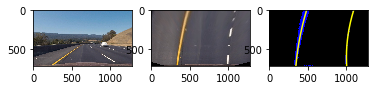

In [9]:
img_test1 = mpimg.imread('test_images/test3.jpg')
mtx,dist = get_coeff()
img_test1 = distortion_correction(img_test1,mtx,dist)
binarized_test1,temp =  pipeline_binarize1(img_test1)
binary_warped = do_persp(binarized_test1,M)
binary_warped = np.asarray(binary_warped,dtype=np.uint8)

plt.show()

left_line = Line()
right_line = Line()

left_line,right_line = findlinesfirst((binary_warped),left_line,right_line,650)

#left_curverad,right_curverad,shiftinmm = curvature_cal(binary_warped,left_fitx,right_fitx,ploty)

plt.figure(5)
ww= np.dstack((binary_warped*0, binary_warped*0, binary_warped*255)) 
plt.subplot(131)
plt.imshow(img_test1)
plt.subplot(132)
plt.imshow(do_persp(img_test1,M))
plt.subplot(133)
plt.imshow(ww)
plt.plot(left_line.allx, left_line.ally, color='yellow')
plt.plot(right_line.allx, left_line.ally, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()
#print(left_curverad)
#print(right_curverad)
#print(shiftinmm)

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Process Image Function 

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #print(image.shape)
    global left_line
    global right_line
    global camConfig
    global lane_Width
    global no_grad
    
    img_undistorted = distortion_correction(image,camConfig.mtx,camConfig.dist)
    binarized1,temp =  pipeline_binarize1(img_undistorted,no_grad)
    binary_warped = do_persp(binarized1,camConfig.M)
    binary_warped = np.asarray(binary_warped,dtype=np.uint8)
    binary_warped = cv2.morphologyEx(binary_warped, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))
    
    
    if len(left_line.line_fits)==0 :
        left_line,right_line = findlinesfirst((binary_warped),left_line,right_line,lane_Width)
    else:
        left_line,right_line = findlinescont((binary_warped), left_line.line_fits[-1],
                                    right_line.line_fits[-1],left_line,right_line,lane_Width)



        
    if len(left_line.line_fits)>0:
        left_line,right_line = update_lines(binary_warped,left_line,right_line,camConfig,lane_Width)
    else:
        left_line.line_fits.append(left_line.current_fit)
        right_line.line_fits.append(right_line.current_fit)
        left_line.recent_xfitted = left_line.allx
        right_line.recent_xfitted = right_line.allx
      
    left_line,right_line = curvature_cal(binary_warped,left_line,right_line)
   
    lane_mask = get_lane_mask(binary_warped,left_line.allx,right_line.allx,left_line.ally,camConfig.inv_M)
    
    binary_warped = do_persp(binary_warped,camConfig.inv_M)
    
    #warpage= np.dstack((lane_mask*0, lane_mask*0, lane_mask)) # making the original road pixels 3 color channels
    ww = np.dstack((binary_warped*0,binary_warped*0,binary_warped*255))
    warpage = np.asarray(lane_mask,dtype=np.uint8)
    image = cv2.addWeighted(image, 0.7, warpage,0.3, 0.0)
    #image = cv2.addWeighted(image, 0.2, ww,1, 0.0)
        
           
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = 'left_curverad: '+str(int(left_line.radius_of_curvature))
    str2 = 'right_curverad: '+str(int(right_line.radius_of_curvature))
    str3 =  'shift_from_center: ' + str(np.abs(left_line.line_base_pos - right_line.line_base_pos))
    cv2.putText(image,str1,(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,str2,(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,str3,(100,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    return image

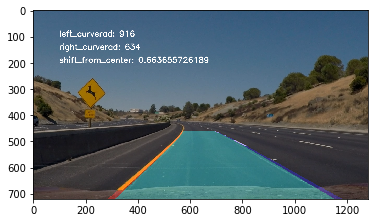

[MoviePy] >>>> Building video test_videos_output/video1.mp4
[MoviePy] Writing video test_videos_output/video1.mp4


100%|█████████▉| 1260/1261 [05:05<00:00,  4.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/video1.mp4 

CPU times: user 5min 51s, sys: 31.4 s, total: 6min 22s
Wall time: 5min 6s


In [12]:
import os
if not os.path.exists('test_videos_output'):
    os.mkdir('test_videos_output')
white_output = 'test_videos_output/video1.mp4'
mtx,dist = get_coeff()
M = getperpcoeff()
invM = getinvperpcoeff()
lane_Width = 650
no_grad = 0

camConfig = Cameraconfig(mtx,dist,M,invM,lane_Width)
left_line = Line()
right_line = Line()
img_test1 = mpimg.imread('test_images/test2.jpg')
img = process_image(img_test1)
plt.figure(0)
plt.imshow(img)
plt.show()
left_line.line_fits = []
right_line.line_fits = []
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(10,14)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [13]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [14]:
import os
if not os.path.exists('test_videos_output'):
    os.mkdir('test_videos_output')
white_output = 'test_videos_output/video2.mp4'
mtx,dist = get_coeff()
M = getperpcoeff()
invM = getinvperpcoeff()
lane_Width = 650
no_grad=1

camConfig = Cameraconfig(mtx,dist,M,invM,lane_Width)
left_line = Line()
right_line = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/video2.mp4
[MoviePy] Writing video test_videos_output/video2.mp4


100%|██████████| 485/485 [02:02<00:00,  4.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/video2.mp4 

CPU times: user 2min 18s, sys: 13.6 s, total: 2min 32s
Wall time: 2min 3s


In [15]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [16]:
import os
if not os.path.exists('test_videos_output'):
    os.mkdir('test_videos_output')
white_output = 'test_videos_output/video3.mp4'
mtx,dist = get_coeff()
M = getperpcoeff()
invM = getinvperpcoeff()
lane_Width = 625

camConfig = Cameraconfig(mtx,dist,M,invM,lane_Width)
left_line = Line()
right_line = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/video3.mp4
[MoviePy] Writing video test_videos_output/video3.mp4


100%|█████████▉| 1199/1200 [05:28<00:00,  3.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/video3.mp4 

CPU times: user 6min 25s, sys: 23.8 s, total: 6min 48s
Wall time: 5min 29s


In [17]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))